In [1096]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from sklearn.metrics import r2_score
from tqdm import tqdm
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np


## Import Data

In [1097]:
os.chdir("C:/Users/luisb/OneDrive/Documents/UT_ORIE/fall23/Applied_ML/project")
#Test Data
test_data = pd.read_csv('data/test_dataset_top.csv')
test_data.drop(test_data.columns[0], axis=1, inplace=True)  #drop unnamed column, first col. in dataset
test_data.dropna(inplace=True)    #drop rows with null values
test_data.drop(test_data[(test_data['RET']>1) | (test_data['RET']<-1)].index, inplace=True)  #drop extreme outliers
output = test_data[['permno','DATE','RET']]  #df to concat results to
test_data.drop(columns=['DATE','permno'], inplace=True)  #drop date and stock ticker columns, not needed for training

#Train Data
train_data = pd.read_csv('data/train_dataset_top.csv', index_col=None)
train_data.drop(train_data.columns[0], axis=1, inplace=True)
train_data.dropna(inplace=True)   #drop rows with null values
train_data.drop(train_data[(train_data['RET']>1) | (train_data['RET']<-1)].index, inplace=True)
train_data.drop(columns=['DATE','permno'], inplace=True) #drop date and stock ticker columns, not needed for training

#Validation Data
val_data = pd.read_csv('data/val_dataset_top.csv')
val_data.drop(val_data.columns[0], axis=1, inplace=True)
val_data.dropna(inplace=True)    #drop rows with null values
val_data.drop(val_data[(val_data['RET']>1) | (val_data['RET']<-1)].index, inplace=True)
val_data.drop(columns=['DATE','permno'], inplace=True) #drop date and stock ticker columns, not needed for training



In [1098]:
train_data.head() 

,mvel1,beta,betasq,chmom,dolvol,idiovol,indmom,mom1m,mom6m,mom12m,...,invest*dfy,invest*svar,absacc*dp_sp,absacc*ep_sp,absacc*bm_sp,absacc*ntis,absacc*tbl,absacc*tms,absacc*dfy,absacc*svar
0,1.000000,-0.392488,-0.843512,0.319507,0.968018,-0.718208,-0.604590,-0.119343,-0.438897,-0.687399,...,-0.365988,-0.374302,-0.754788,-0.816891,-0.810511,-0.285030,-0.969760,-0.831976,-0.819573,-0.974298
1,0.993421,-0.373529,-0.832350,0.346878,0.971090,-0.711564,-0.659332,-0.020089,-0.374176,-0.641790,...,-0.379144,-0.372207,-0.774483,-0.819861,-0.822897,-0.271672,-0.957228,-0.872915,-0.837108,-0.960373
2,0.930708,-0.359465,-0.823821,0.354844,0.965641,-0.717428,-0.627439,-0.256641,-0.277002,-0.610022,...,-0.364658,-0.377033,-0.761046,-0.813335,-0.812858,-0.275138,-0.969760,-0.853350,-0.815734,-0.985970
3,0.921025,-0.351181,-0.818698,0.343828,0.974312,-0.720239,-0.596675,-0.189967,-0.364706,-0.661673,...,-0.367983,-0.375246,-0.761733,-0.818006,-0.814626,-0.281153,-0.969760,-0.845632,-0.825331,-0.978333
4,0.906199,-0.377502,-0.834720,0.362267,0.956196,-0.719959,-0.620920,-0.267217,-0.344581,-0.681327,...,-0.358673,-0.373687,-0.758060,-0.823116,-0.811265,-0.284888,-0.954640,-0.845632,-0.798459,-0.971669


In [1099]:
#Prepare data
X_train_tensor = torch.tensor(train_data.drop(columns=['RET']).values, dtype=torch.float32)
y_train_tensor = torch.tensor(train_data['RET'].values, dtype=torch.float32)

X_test_tensor = torch.tensor(test_data.drop(columns=['RET']).values, dtype=torch.float32)
y_test_tensor = torch.tensor(test_data['RET'].values, dtype=torch.float32)

X_val_tensor = torch.tensor(val_data.drop(columns=['RET']).values, dtype=torch.float32)
y_val_tensor = torch.tensor(val_data['RET'].values, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)


batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [1100]:
number_of_features = train_dataset[0][0].shape[0]
print(number_of_features)

#Loss function, for all three models
criterion = nn.MSELoss()  # MSE Loss.   (This one is more sensitive to outliers)
#criterion = nn.L1Loss()    #MAE Loss.

911


## MLP with 1 hidden layer

In [1101]:
#MLP with 1 hidden layer
class MLP1(nn.Module):
    def __init__(self, input_size, hidden_size1, output_size):
        super(MLP1, self).__init__()

        #Create fully connected layers
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, output_size)

        #Batch Normalization
        #self.bn1 = nn.BatchNorm1d(hidden_size1)


    def forward(self, x):
        x = x.view(-1, number_of_features)
        #x = F.leaky_relu_(self.fc1(x), negative_slope=0.1)
        x = F.relu(self.fc1(x))

        #x = torch.sigmoid(self.fc2(x)) - 0.5
        x = torch.tanh(self.fc2(x))
        #x = self.fc2(x)
        return x

In [1102]:
# Adjust input_size based on the number of features in your input data
input_size = number_of_features
print(f'Input Size: {input_size}')
hidden_size1 = 32
output_size = 1  # For regression
learning_rate = 0.00000001

model = MLP1(input_size, hidden_size1, output_size)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)



# R-squared function
def calculate_r_squared(y_true, y_pred):
    return r2_score(y_true, y_pred)

Input Size: 911


In [1103]:
#Number of Epochs
num_epochs = 35

#Storage
train_losses = []
val_losses = []
val_r_squared_values = []

#Training
for epoch in range(num_epochs):
    model.train()
    for batch_x, batch_y in tqdm(train_loader):
        outputs = model(batch_x)

        loss = criterion(outputs, batch_y.unsqueeze(1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    #Validation
    model.eval()
    val_predictions = []
    val_targets = []
    val_loss = 0.0
    with torch.no_grad():
        for val_batch_x, val_batch_y in tqdm(val_loader):
            val_outputs = model(val_batch_x)
            val_loss += criterion(val_outputs, val_batch_y.unsqueeze(1)).item()

            #Validation Set R-squared
            val_predictions.extend(val_outputs.numpy())
            val_targets.extend(val_batch_y.unsqueeze(1).numpy())

    val_loss /= len(val_loader)
    val_r_squared = calculate_r_squared(val_targets, val_predictions)

    #Storage
    train_losses.append(loss.item())
    val_losses.append(val_loss)
    val_r_squared_values.append(val_r_squared)

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}, Validation R-squared: {val_r_squared:.4f}')

print('Training finished.')

100%|██████████| 374/374 [00:00<00:00, 897.94it/s]


Epoch 1/35, Loss: 0.2672, Val Loss: 0.2013, Validation R-squared: -34.8440


100%|██████████| 374/374 [00:00<00:00, 889.02it/s]


Epoch 2/35, Loss: 0.2741, Val Loss: 0.1950, Validation R-squared: -33.7165


100%|██████████| 374/374 [00:00<00:00, 877.41it/s]


Epoch 3/35, Loss: 0.2709, Val Loss: 0.1887, Validation R-squared: -32.6027


100%|██████████| 374/374 [00:00<00:00, 919.82it/s]


Epoch 4/35, Loss: 0.2430, Val Loss: 0.1825, Validation R-squared: -31.5035


100%|██████████| 374/374 [00:00<00:00, 835.88it/s]


Epoch 5/35, Loss: 0.2373, Val Loss: 0.1765, Validation R-squared: -30.4208


100%|██████████| 374/374 [00:00<00:00, 876.07it/s]


Epoch 6/35, Loss: 0.2351, Val Loss: 0.1705, Validation R-squared: -29.3542


100%|██████████| 374/374 [00:00<00:00, 825.32it/s]


Epoch 7/35, Loss: 0.2376, Val Loss: 0.1646, Validation R-squared: -28.3043


100%|██████████| 374/374 [00:00<00:00, 578.18it/s]


Epoch 8/35, Loss: 0.2137, Val Loss: 0.1588, Validation R-squared: -27.2719


100%|██████████| 374/374 [00:00<00:00, 860.85it/s]


Epoch 9/35, Loss: 0.2091, Val Loss: 0.1531, Validation R-squared: -26.2576


100%|██████████| 374/374 [00:00<00:00, 805.18it/s]


Epoch 10/35, Loss: 0.2360, Val Loss: 0.1475, Validation R-squared: -25.2619


100%|██████████| 374/374 [00:00<00:00, 901.18it/s]


Epoch 11/35, Loss: 0.1775, Val Loss: 0.1420, Validation R-squared: -24.2859


100%|██████████| 374/374 [00:00<00:00, 854.03it/s]


Epoch 12/35, Loss: 0.2108, Val Loss: 0.1366, Validation R-squared: -23.3292


100%|██████████| 374/374 [00:00<00:00, 853.16it/s]


Epoch 13/35, Loss: 0.1735, Val Loss: 0.1314, Validation R-squared: -22.3921


100%|██████████| 374/374 [00:00<00:00, 869.05it/s]


Epoch 14/35, Loss: 0.1744, Val Loss: 0.1262, Validation R-squared: -21.4751


100%|██████████| 374/374 [00:00<00:00, 873.05it/s]


Epoch 15/35, Loss: 0.1583, Val Loss: 0.1212, Validation R-squared: -20.5786


100%|██████████| 374/374 [00:00<00:00, 857.47it/s]


Epoch 16/35, Loss: 0.1834, Val Loss: 0.1163, Validation R-squared: -19.7026


100%|██████████| 374/374 [00:00<00:00, 905.55it/s]


Epoch 17/35, Loss: 0.1643, Val Loss: 0.1115, Validation R-squared: -18.8475


100%|██████████| 374/374 [00:00<00:00, 853.03it/s]


Epoch 18/35, Loss: 0.1514, Val Loss: 0.1068, Validation R-squared: -18.0131


100%|██████████| 374/374 [00:00<00:00, 881.41it/s]


Epoch 19/35, Loss: 0.1252, Val Loss: 0.1022, Validation R-squared: -17.1995


100%|██████████| 374/374 [00:00<00:00, 899.74it/s]


Epoch 20/35, Loss: 0.1594, Val Loss: 0.0978, Validation R-squared: -16.4067


100%|██████████| 374/374 [00:00<00:00, 950.38it/s]


Epoch 21/35, Loss: 0.1246, Val Loss: 0.0934, Validation R-squared: -15.6347


100%|██████████| 374/374 [00:00<00:00, 798.42it/s]


Epoch 22/35, Loss: 0.1329, Val Loss: 0.0892, Validation R-squared: -14.8841


100%|██████████| 374/374 [00:00<00:00, 971.95it/s]


Epoch 23/35, Loss: 0.1210, Val Loss: 0.0851, Validation R-squared: -14.1549


100%|██████████| 374/374 [00:00<00:00, 898.66it/s]


Epoch 24/35, Loss: 0.1109, Val Loss: 0.0811, Validation R-squared: -13.4467


100%|██████████| 374/374 [00:00<00:00, 901.95it/s]


Epoch 25/35, Loss: 0.1148, Val Loss: 0.0773, Validation R-squared: -12.7586


100%|██████████| 374/374 [00:00<00:00, 939.73it/s]


Epoch 26/35, Loss: 0.0979, Val Loss: 0.0735, Validation R-squared: -12.0916


100%|██████████| 374/374 [00:00<00:00, 976.09it/s]


Epoch 27/35, Loss: 0.0834, Val Loss: 0.0699, Validation R-squared: -11.4443


100%|██████████| 374/374 [00:00<00:00, 915.27it/s]


Epoch 28/35, Loss: 0.0805, Val Loss: 0.0664, Validation R-squared: -10.8171


100%|██████████| 374/374 [00:00<00:00, 823.99it/s]


Epoch 29/35, Loss: 0.0825, Val Loss: 0.0630, Validation R-squared: -10.2105


100%|██████████| 374/374 [00:00<00:00, 933.79it/s] 


Epoch 30/35, Loss: 0.0832, Val Loss: 0.0597, Validation R-squared: -9.6236


100%|██████████| 374/374 [00:00<00:00, 938.87it/s]


Epoch 31/35, Loss: 0.0755, Val Loss: 0.0565, Validation R-squared: -9.0565


100%|██████████| 374/374 [00:00<00:00, 892.24it/s]


Epoch 32/35, Loss: 0.0866, Val Loss: 0.0534, Validation R-squared: -8.5093


100%|██████████| 374/374 [00:00<00:00, 910.50it/s]


Epoch 33/35, Loss: 0.0642, Val Loss: 0.0504, Validation R-squared: -7.9810


100%|██████████| 374/374 [00:00<00:00, 883.92it/s]


Epoch 34/35, Loss: 0.0696, Val Loss: 0.0476, Validation R-squared: -7.4725


100%|██████████| 374/374 [00:00<00:00, 881.01it/s]

Epoch 35/35, Loss: 0.0645, Val Loss: 0.0448, Validation R-squared: -6.9829
Training finished.


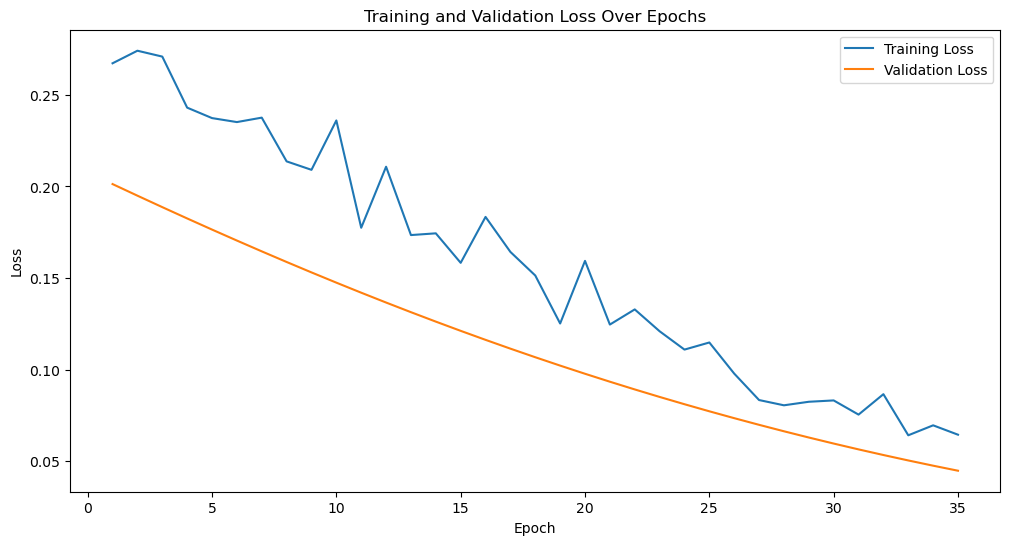

In [1104]:
# Plotting
epochs = np.arange(1, num_epochs + 1)
#Losses
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

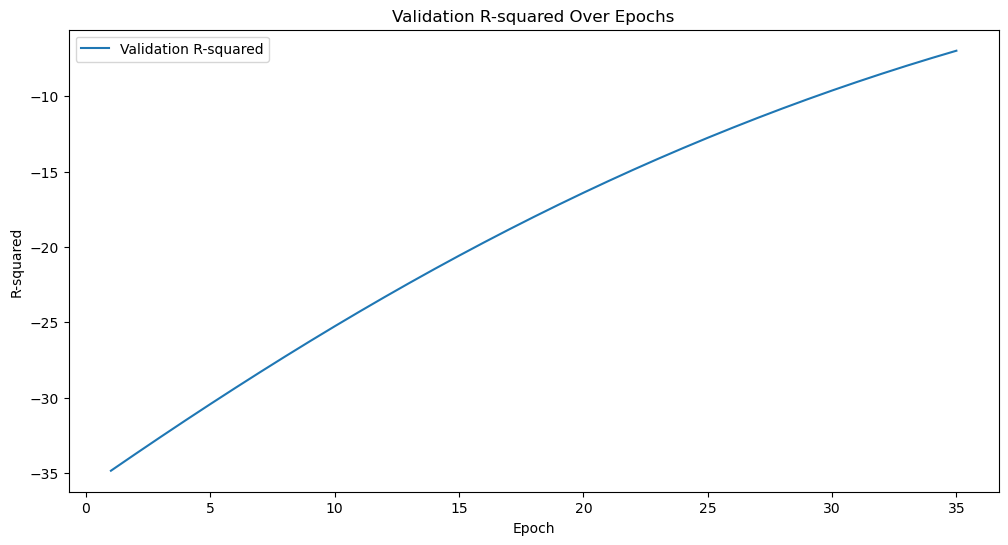

In [1105]:
#R-squared values
plt.figure(figsize=(12, 6))
plt.plot(epochs, val_r_squared_values, label='Validation R-squared')
plt.xlabel('Epoch')
plt.ylabel('R-squared')
plt.title('Validation R-squared Over Epochs')
plt.legend()
plt.show()

In [1106]:
# Testing
model.eval()
test_loss = 0.0
all_predictions = []
all_targets = []

with torch.no_grad():
    for test_batch_x, test_batch_y in test_loader:
        test_outputs = model(test_batch_x)
        test_batch_y = test_batch_y.view(-1, 1)  # Ensure the target tensor has shape [batch_size, 1]
        test_loss += criterion(test_outputs, test_batch_y).item()

        all_predictions.extend(test_outputs.numpy())
        all_targets.extend(test_batch_y.numpy())

test_loss /= len(test_loader)

# Calculate R-squared
r_squared_MLP1 = calculate_r_squared(all_targets, all_predictions)

print(f'Test Loss: {test_loss:.4f}')
print(f'R-squared: {r_squared_MLP1:.4f}')

print('Training and Testing finished.')

Test Loss: 0.0617
R-squared: -4.8502
Training and Testing finished.


Text(0.5, 1.0, 'Actual vs. Predicted Test Set')

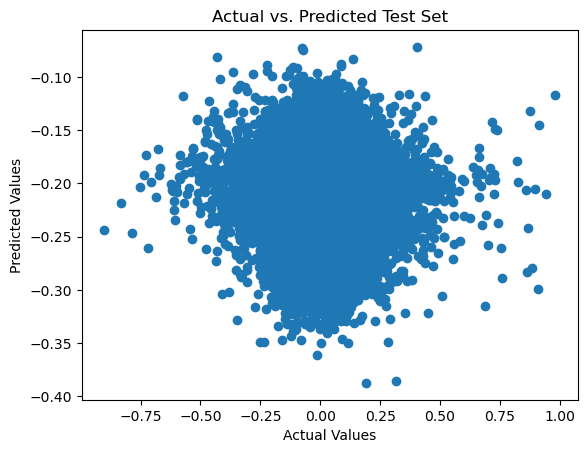

In [1107]:
plt.scatter(all_targets, all_predictions)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Test Set')

In [1108]:
#Export out
predictions = [item for sublist in all_predictions for item in sublist]
output_mlp1 = output.copy()
output_mlp1['pred'] = predictions
output_mlp1.to_csv('output_mlp1.csv',index=False)
output_mlp1.head()

,permno,DATE,RET,pred
0,14593,202112,0.074229,-0.153399
1,14593,202109,-0.068037,-0.189105
2,10107,202111,-0.001236,-0.182977
3,10107,202112,0.017333,-0.184829
4,14593,202111,0.104940,-0.150532


## MLP with 2 hidden layers

In [1109]:
#MLP with 2 hidden layers
class MLP2(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(MLP2, self).__init__()
        
        #Create fully connected layers
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, output_size)

        #Batch Normalization
        #self.bn1 = nn.BatchNorm1d(hidden_size1)
        #self.bn2 = nn.BatchNorm1d(hidden_size2)


    def forward(self, x):
        x = x.view(-1, number_of_features)
        #x = F.leaky_relu(self.fc1(x), negative_slope=0.1)
        #x = F.leaky_relu(self.fc2(x), negative_slope=0.1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        
        #x = torch.sigmoid(self.fc3(x)) - 0.5
        x = torch.tanh(self.fc3(x))
        #x = self.fc3(x)
        return x

In [1110]:
# Adjust input_size based on the number of features in your input data
input_size = number_of_features
print(f'Input Size: {input_size}')
hidden_size1, hidden_size2, = 32, 16
output_size = 1  # For regression
learning_rate = 0.00000001

model = MLP2(input_size, hidden_size1, hidden_size2, output_size)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


# R-squared function
def calculate_r_squared(y_true, y_pred):
    return r2_score(y_true, y_pred)

Input Size: 911


In [1111]:
num_epochs = 45

#Storage
train_losses = []
val_losses = []
val_r_squared_values = []

#Training
for epoch in range(num_epochs):
    model.train()
    for batch_x, batch_y in tqdm(train_loader):
        outputs = model(batch_x)

        loss = criterion(outputs, batch_y.unsqueeze(1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


    #Validation
    model.eval()
    val_predictions = []
    val_targets = []
    val_loss = 0.0
    with torch.no_grad():
        for val_batch_x, val_batch_y in tqdm(val_loader):
            val_outputs = model(val_batch_x)
            val_loss += criterion(val_outputs, val_batch_y.unsqueeze(1)).item()

            #Validation Set R-squared
            val_predictions.extend(val_outputs.numpy())
            val_targets.extend(val_batch_y.unsqueeze(1).numpy())

    val_loss /= len(val_loader)
    val_r_squared = calculate_r_squared(val_targets, val_predictions)

    #Storage
    train_losses.append(loss.item())
    val_losses.append(val_loss)
    val_r_squared_values.append(val_r_squared)


    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}, Validation R-squared: {val_r_squared:.4f}')

print('Training finished.')

100%|██████████| 374/374 [00:00<00:00, 783.76it/s]


Epoch 1/45, Loss: 0.0081, Val Loss: 0.0092, Validation R-squared: -0.6418


100%|██████████| 374/374 [00:00<00:00, 799.70it/s]


Epoch 2/45, Loss: 0.0075, Val Loss: 0.0089, Validation R-squared: -0.5917


100%|██████████| 374/374 [00:00<00:00, 666.93it/s]


Epoch 3/45, Loss: 0.0063, Val Loss: 0.0087, Validation R-squared: -0.5467


100%|██████████| 374/374 [00:00<00:00, 790.85it/s]


Epoch 4/45, Loss: 0.0112, Val Loss: 0.0085, Validation R-squared: -0.5051


100%|██████████| 374/374 [00:00<00:00, 741.50it/s]


Epoch 5/45, Loss: 0.0055, Val Loss: 0.0082, Validation R-squared: -0.4671


100%|██████████| 374/374 [00:00<00:00, 728.05it/s]


Epoch 6/45, Loss: 0.0038, Val Loss: 0.0080, Validation R-squared: -0.4328


100%|██████████| 374/374 [00:00<00:00, 532.27it/s]


Epoch 7/45, Loss: 0.0055, Val Loss: 0.0079, Validation R-squared: -0.4023


100%|██████████| 374/374 [00:00<00:00, 522.88it/s]


Epoch 8/45, Loss: 0.0040, Val Loss: 0.0077, Validation R-squared: -0.3755


100%|██████████| 374/374 [00:00<00:00, 557.03it/s]


Epoch 9/45, Loss: 0.0062, Val Loss: 0.0076, Validation R-squared: -0.3523


100%|██████████| 374/374 [00:00<00:00, 433.41it/s]


Epoch 10/45, Loss: 0.0094, Val Loss: 0.0075, Validation R-squared: -0.3329


100%|██████████| 374/374 [00:00<00:00, 587.60it/s]


Epoch 11/45, Loss: 0.0062, Val Loss: 0.0074, Validation R-squared: -0.3170


100%|██████████| 374/374 [00:00<00:00, 431.04it/s]


Epoch 12/45, Loss: 0.0045, Val Loss: 0.0073, Validation R-squared: -0.3041


100%|██████████| 374/374 [00:00<00:00, 411.51it/s]


Epoch 13/45, Loss: 0.0057, Val Loss: 0.0073, Validation R-squared: -0.2939


100%|██████████| 374/374 [00:01<00:00, 354.94it/s]


Epoch 14/45, Loss: 0.0073, Val Loss: 0.0072, Validation R-squared: -0.2858


100%|██████████| 374/374 [00:00<00:00, 671.60it/s]


Epoch 15/45, Loss: 0.0069, Val Loss: 0.0072, Validation R-squared: -0.2792


100%|██████████| 374/374 [00:00<00:00, 642.24it/s]


Epoch 16/45, Loss: 0.0080, Val Loss: 0.0072, Validation R-squared: -0.2739


100%|██████████| 374/374 [00:00<00:00, 664.56it/s]


Epoch 17/45, Loss: 0.0048, Val Loss: 0.0071, Validation R-squared: -0.2697


100%|██████████| 374/374 [00:00<00:00, 768.77it/s]


Epoch 18/45, Loss: 0.0057, Val Loss: 0.0071, Validation R-squared: -0.2659


100%|██████████| 374/374 [00:00<00:00, 575.80it/s]


Epoch 19/45, Loss: 0.0048, Val Loss: 0.0071, Validation R-squared: -0.2631


100%|██████████| 374/374 [00:00<00:00, 810.17it/s]


Epoch 20/45, Loss: 0.0247, Val Loss: 0.0071, Validation R-squared: -0.2604


100%|██████████| 374/374 [00:00<00:00, 680.34it/s]


Epoch 21/45, Loss: 0.0031, Val Loss: 0.0071, Validation R-squared: -0.2580


100%|██████████| 374/374 [00:00<00:00, 717.87it/s]


Epoch 22/45, Loss: 0.0091, Val Loss: 0.0071, Validation R-squared: -0.2559


100%|██████████| 374/374 [00:00<00:00, 802.39it/s]


Epoch 23/45, Loss: 0.0025, Val Loss: 0.0070, Validation R-squared: -0.2539


100%|██████████| 374/374 [00:01<00:00, 290.32it/s]


Epoch 24/45, Loss: 0.0073, Val Loss: 0.0070, Validation R-squared: -0.2522


100%|██████████| 374/374 [00:01<00:00, 309.64it/s]


Epoch 25/45, Loss: 0.0051, Val Loss: 0.0070, Validation R-squared: -0.2505


100%|██████████| 374/374 [00:01<00:00, 315.61it/s]


Epoch 26/45, Loss: 0.0059, Val Loss: 0.0070, Validation R-squared: -0.2490


100%|██████████| 374/374 [00:01<00:00, 294.00it/s]


Epoch 27/45, Loss: 0.0077, Val Loss: 0.0070, Validation R-squared: -0.2475


100%|██████████| 374/374 [00:01<00:00, 300.20it/s]


Epoch 28/45, Loss: 0.0050, Val Loss: 0.0070, Validation R-squared: -0.2459


100%|██████████| 374/374 [00:01<00:00, 291.77it/s]


Epoch 29/45, Loss: 0.0089, Val Loss: 0.0070, Validation R-squared: -0.2445


100%|██████████| 374/374 [00:01<00:00, 302.66it/s]


Epoch 30/45, Loss: 0.0079, Val Loss: 0.0070, Validation R-squared: -0.2431


100%|██████████| 374/374 [00:01<00:00, 295.55it/s]


Epoch 31/45, Loss: 0.0054, Val Loss: 0.0070, Validation R-squared: -0.2417


100%|██████████| 374/374 [00:01<00:00, 297.16it/s]


Epoch 32/45, Loss: 0.0050, Val Loss: 0.0070, Validation R-squared: -0.2404


100%|██████████| 374/374 [00:01<00:00, 283.34it/s]


Epoch 33/45, Loss: 0.0047, Val Loss: 0.0070, Validation R-squared: -0.2389


100%|██████████| 374/374 [00:01<00:00, 302.74it/s]


Epoch 34/45, Loss: 0.0040, Val Loss: 0.0070, Validation R-squared: -0.2375


100%|██████████| 374/374 [00:01<00:00, 299.91it/s]


Epoch 35/45, Loss: 0.0093, Val Loss: 0.0069, Validation R-squared: -0.2362


100%|██████████| 374/374 [00:01<00:00, 326.00it/s]


Epoch 36/45, Loss: 0.0046, Val Loss: 0.0069, Validation R-squared: -0.2347


100%|██████████| 374/374 [00:01<00:00, 306.60it/s]


Epoch 37/45, Loss: 0.0136, Val Loss: 0.0069, Validation R-squared: -0.2335


100%|██████████| 374/374 [00:01<00:00, 300.48it/s]


Epoch 38/45, Loss: 0.0026, Val Loss: 0.0069, Validation R-squared: -0.2322


100%|██████████| 374/374 [00:01<00:00, 311.51it/s]


Epoch 39/45, Loss: 0.0047, Val Loss: 0.0069, Validation R-squared: -0.2309


100%|██████████| 374/374 [00:01<00:00, 302.82it/s]


Epoch 40/45, Loss: 0.0044, Val Loss: 0.0069, Validation R-squared: -0.2298


100%|██████████| 374/374 [00:01<00:00, 301.79it/s]


Epoch 41/45, Loss: 0.0106, Val Loss: 0.0069, Validation R-squared: -0.2287


100%|██████████| 374/374 [00:01<00:00, 298.50it/s]


Epoch 42/45, Loss: 0.0083, Val Loss: 0.0069, Validation R-squared: -0.2273


100%|██████████| 374/374 [00:01<00:00, 298.30it/s]


Epoch 43/45, Loss: 0.0111, Val Loss: 0.0069, Validation R-squared: -0.2260


100%|██████████| 374/374 [00:01<00:00, 312.09it/s]


Epoch 44/45, Loss: 0.0050, Val Loss: 0.0069, Validation R-squared: -0.2248


100%|██████████| 374/374 [00:01<00:00, 308.65it/s]


Epoch 45/45, Loss: 0.0080, Val Loss: 0.0069, Validation R-squared: -0.2237
Training finished.


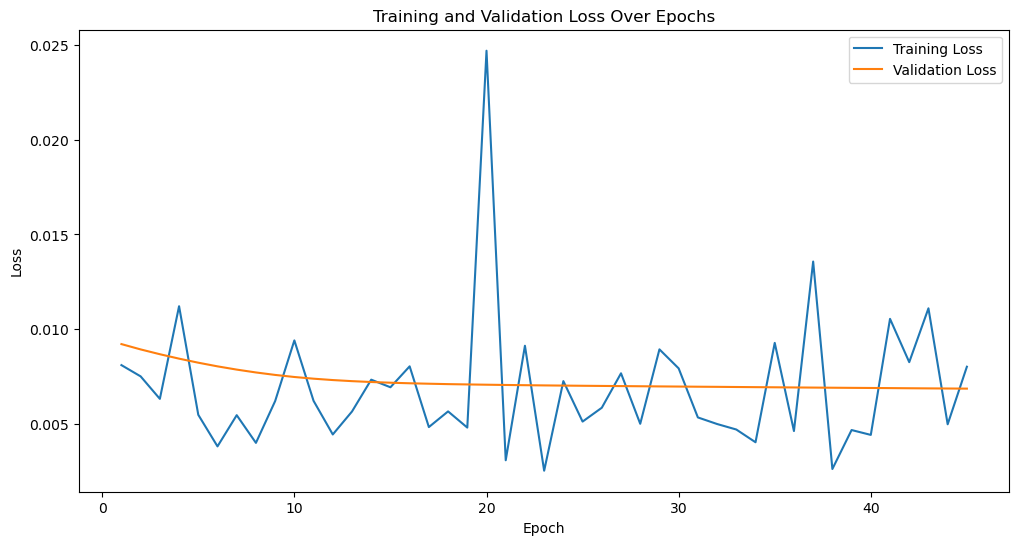

In [1112]:
# Plotting
epochs = np.arange(1, num_epochs + 1)
#Losses
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

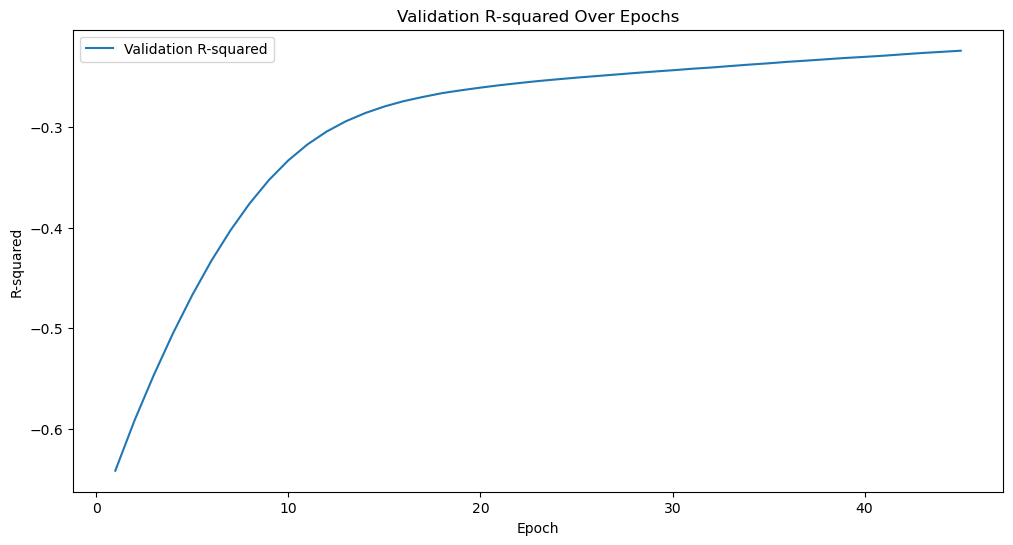

In [1113]:
#R-squared values
plt.figure(figsize=(12, 6))
plt.plot(epochs, val_r_squared_values, label='Validation R-squared')
plt.xlabel('Epoch')
plt.ylabel('R-squared')
plt.title('Validation R-squared Over Epochs')
plt.legend()
plt.show()

In [1114]:
# Testing
model.eval()
test_loss = 0.0
all_predictions = []
all_targets = []

with torch.no_grad():
    for test_batch_x, test_batch_y in test_loader:
        test_outputs = model(test_batch_x)
        test_batch_y = test_batch_y.view(-1, 1)  # Ensure the target tensor has shape [batch_size, 1]
        test_loss += criterion(test_outputs, test_batch_y).item()

        all_predictions.extend(test_outputs.numpy())
        all_targets.extend(test_batch_y.numpy())

test_loss /= len(test_loader)

# Calculate R-squared
r_squared_MLP2 = calculate_r_squared(all_targets, all_predictions)

print(f'Test Loss: {test_loss:.4f}')
print(f'R-squared: {r_squared_MLP2:.4f}')

print('Training and Testing finished.')

Test Loss: 0.0107
R-squared: -0.0098
Training and Testing finished.


Text(0.5, 1.0, 'Actual vs. Predicted Test Set')

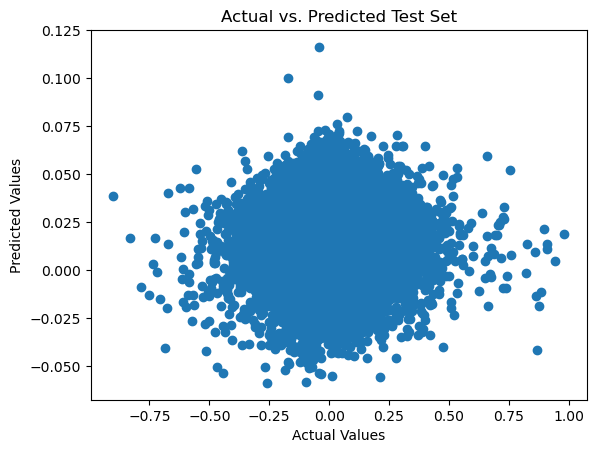

In [1115]:
plt.scatter(all_targets, all_predictions)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Test Set')

In [1116]:
#Export out
predictions = [item for sublist in all_predictions for item in sublist]
output_mlp2 = output.copy()
output_mlp2['pred'] = predictions
output_mlp2.to_csv('output_mlp2.csv', index=False)
output_mlp2.head()

,permno,DATE,RET,pred
0,14593,202112,0.074229,0.036854
1,14593,202109,-0.068037,0.034304
2,10107,202111,-0.001236,0.015105
3,10107,202112,0.017333,0.018004
4,14593,202111,0.104940,0.033325


## MLP with 3 hidden layers

In [1117]:
#Best results: three leakys and a single sigmoid with a 0.5 shift. 
#MLP with 3 hidden layers
class MLP3(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, output_size):
        super(MLP3, self).__init__()
        
        #Create fully connected layers
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.fc4 = nn.Linear(hidden_size3, output_size)

        #Batch Normalization
        #self.bn1 = nn.BatchNorm1d(hidden_size1)
        #self.bn2 = nn.BatchNorm1d(hidden_size2)
        #self.bn3 = nn.BatchNorm1d(hidden_size3)

    def forward(self, x):
        x = x.view(-1, number_of_features)
        #x = F.leaky_relu(self.fc1(x), negative_slope=0.1)
        #x = F.leaky_relu(self.fc2(x), negative_slope=0.1)
        #x = F.leaky_relu(self.fc3(x), negative_slope=0.1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))

        #x = self.fc4(x)
        #x = torch.sigmoid(self.fc4(x)) - 0.5
        x = torch.tanh(self.fc4(x))
        return x

In [1118]:
# Adjust input_size based on the number of features in your input data
input_size = number_of_features
print(f'Input Size: {input_size}')
hidden_size1, hidden_size2, hidden_size3 = 32, 16, 8
output_size = 1  # For regression
learning_rate = 0.00000001

model = MLP3(input_size, hidden_size1, hidden_size2, hidden_size3, output_size) 
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# R-squared function
def calculate_r_squared(y_true, y_pred):
    return r2_score(y_true, y_pred)

Input Size: 911


In [1119]:
#Epochs
num_epochs = 50

#Storage
train_losses = []
val_losses = []
val_r_squared_values = []

#Training
for epoch in range(num_epochs):
    model.train()
    for batch_x, batch_y in tqdm(train_loader):
        outputs = model(batch_x)

        loss = criterion(outputs, batch_y.unsqueeze(1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


    #Validation
    model.eval()
    val_predictions = []
    val_targets = []
    val_loss = 0.0
    with torch.no_grad():
        for val_batch_x, val_batch_y in tqdm(val_loader):
            val_outputs = model(val_batch_x)
            val_loss += criterion(val_outputs, val_batch_y.unsqueeze(1)).item()

            #Validation Set R-squared
            val_predictions.extend(val_outputs.numpy())
            val_targets.extend(val_batch_y.unsqueeze(1).numpy())

    val_loss /= len(val_loader)
    val_r_squared = calculate_r_squared(val_targets, val_predictions)

    #Storage
    train_losses.append(loss.item())
    val_losses.append(val_loss)
    val_r_squared_values.append(val_r_squared)

    
    
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}, Validation R-squared: {val_r_squared:.4f}')

print('Training finished.')


100%|██████████| 374/374 [00:01<00:00, 292.11it/s]


Epoch 1/50, Loss: 0.0161, Val Loss: 0.0113, Validation R-squared: -1.0034


100%|██████████| 374/374 [00:01<00:00, 289.59it/s]


Epoch 2/50, Loss: 0.0304, Val Loss: 0.0112, Validation R-squared: -0.9945


100%|██████████| 374/374 [00:01<00:00, 277.94it/s]


Epoch 3/50, Loss: 0.0122, Val Loss: 0.0112, Validation R-squared: -0.9856


100%|██████████| 374/374 [00:01<00:00, 259.21it/s]


Epoch 4/50, Loss: 0.0083, Val Loss: 0.0111, Validation R-squared: -0.9770


100%|██████████| 374/374 [00:01<00:00, 323.53it/s]


Epoch 5/50, Loss: 0.0137, Val Loss: 0.0111, Validation R-squared: -0.9687


100%|██████████| 374/374 [00:01<00:00, 283.19it/s]


Epoch 6/50, Loss: 0.0167, Val Loss: 0.0110, Validation R-squared: -0.9606


100%|██████████| 374/374 [00:01<00:00, 302.01it/s]


Epoch 7/50, Loss: 0.0074, Val Loss: 0.0110, Validation R-squared: -0.9528


100%|██████████| 374/374 [00:01<00:00, 294.02it/s]


Epoch 8/50, Loss: 0.0150, Val Loss: 0.0109, Validation R-squared: -0.9455


100%|██████████| 374/374 [00:01<00:00, 290.60it/s]


Epoch 9/50, Loss: 0.0143, Val Loss: 0.0109, Validation R-squared: -0.9385


100%|██████████| 374/374 [00:01<00:00, 297.65it/s]


Epoch 10/50, Loss: 0.0132, Val Loss: 0.0109, Validation R-squared: -0.9320


100%|██████████| 374/374 [00:01<00:00, 289.85it/s]


Epoch 11/50, Loss: 0.0100, Val Loss: 0.0108, Validation R-squared: -0.9259


100%|██████████| 374/374 [00:01<00:00, 292.05it/s]


Epoch 12/50, Loss: 0.0272, Val Loss: 0.0108, Validation R-squared: -0.9201


100%|██████████| 374/374 [00:01<00:00, 284.31it/s]


Epoch 13/50, Loss: 0.0094, Val Loss: 0.0108, Validation R-squared: -0.9146


100%|██████████| 374/374 [00:01<00:00, 288.02it/s]


Epoch 14/50, Loss: 0.0124, Val Loss: 0.0107, Validation R-squared: -0.9095


100%|██████████| 374/374 [00:01<00:00, 294.24it/s]


Epoch 15/50, Loss: 0.0089, Val Loss: 0.0107, Validation R-squared: -0.9046


100%|██████████| 374/374 [00:01<00:00, 291.52it/s]


Epoch 16/50, Loss: 0.0119, Val Loss: 0.0107, Validation R-squared: -0.8998


100%|██████████| 374/374 [00:01<00:00, 286.90it/s]


Epoch 17/50, Loss: 0.0095, Val Loss: 0.0106, Validation R-squared: -0.8953


100%|██████████| 374/374 [00:01<00:00, 289.79it/s]


Epoch 18/50, Loss: 0.0202, Val Loss: 0.0106, Validation R-squared: -0.8908


100%|██████████| 374/374 [00:01<00:00, 319.22it/s]


Epoch 19/50, Loss: 0.0080, Val Loss: 0.0106, Validation R-squared: -0.8865


100%|██████████| 374/374 [00:01<00:00, 256.93it/s]


Epoch 20/50, Loss: 0.0139, Val Loss: 0.0106, Validation R-squared: -0.8823


100%|██████████| 374/374 [00:01<00:00, 288.09it/s]


Epoch 21/50, Loss: 0.0139, Val Loss: 0.0105, Validation R-squared: -0.8781


100%|██████████| 374/374 [00:01<00:00, 283.36it/s]


Epoch 22/50, Loss: 0.0169, Val Loss: 0.0105, Validation R-squared: -0.8740


100%|██████████| 374/374 [00:01<00:00, 289.54it/s]


Epoch 23/50, Loss: 0.0104, Val Loss: 0.0105, Validation R-squared: -0.8700


100%|██████████| 374/374 [00:01<00:00, 288.91it/s]


Epoch 24/50, Loss: 0.0131, Val Loss: 0.0105, Validation R-squared: -0.8660


100%|██████████| 374/374 [00:01<00:00, 296.43it/s]


Epoch 25/50, Loss: 0.0115, Val Loss: 0.0105, Validation R-squared: -0.8621


100%|██████████| 374/374 [00:01<00:00, 293.28it/s]


Epoch 26/50, Loss: 0.0123, Val Loss: 0.0104, Validation R-squared: -0.8583


100%|██████████| 374/374 [00:01<00:00, 291.92it/s]


Epoch 27/50, Loss: 0.0091, Val Loss: 0.0104, Validation R-squared: -0.8546


100%|██████████| 374/374 [00:01<00:00, 259.48it/s]


Epoch 28/50, Loss: 0.0101, Val Loss: 0.0104, Validation R-squared: -0.8509


100%|██████████| 374/374 [00:01<00:00, 294.31it/s]


Epoch 29/50, Loss: 0.0120, Val Loss: 0.0104, Validation R-squared: -0.8472


100%|██████████| 374/374 [00:01<00:00, 290.96it/s]


Epoch 30/50, Loss: 0.0111, Val Loss: 0.0104, Validation R-squared: -0.8436


100%|██████████| 374/374 [00:01<00:00, 287.58it/s]


Epoch 31/50, Loss: 0.0090, Val Loss: 0.0103, Validation R-squared: -0.8400


100%|██████████| 374/374 [00:01<00:00, 304.36it/s]


Epoch 32/50, Loss: 0.0138, Val Loss: 0.0103, Validation R-squared: -0.8363


100%|██████████| 374/374 [00:01<00:00, 292.60it/s]


Epoch 33/50, Loss: 0.0088, Val Loss: 0.0103, Validation R-squared: -0.8328


100%|██████████| 374/374 [00:01<00:00, 295.36it/s]


Epoch 34/50, Loss: 0.0114, Val Loss: 0.0103, Validation R-squared: -0.8292


100%|██████████| 374/374 [00:01<00:00, 301.69it/s]


Epoch 35/50, Loss: 0.0082, Val Loss: 0.0103, Validation R-squared: -0.8256


100%|██████████| 374/374 [00:01<00:00, 276.06it/s]


Epoch 36/50, Loss: 0.0121, Val Loss: 0.0102, Validation R-squared: -0.8220


100%|██████████| 374/374 [00:01<00:00, 306.67it/s]


Epoch 37/50, Loss: 0.0113, Val Loss: 0.0102, Validation R-squared: -0.8185


100%|██████████| 374/374 [00:01<00:00, 307.75it/s]


Epoch 38/50, Loss: 0.0132, Val Loss: 0.0102, Validation R-squared: -0.8150


100%|██████████| 374/374 [00:01<00:00, 274.39it/s]


Epoch 39/50, Loss: 0.0102, Val Loss: 0.0102, Validation R-squared: -0.8115


100%|██████████| 374/374 [00:01<00:00, 296.92it/s]


Epoch 40/50, Loss: 0.0090, Val Loss: 0.0102, Validation R-squared: -0.8081


100%|██████████| 374/374 [00:01<00:00, 298.17it/s]


Epoch 41/50, Loss: 0.0119, Val Loss: 0.0101, Validation R-squared: -0.8047


100%|██████████| 374/374 [00:01<00:00, 311.24it/s]


Epoch 42/50, Loss: 0.0074, Val Loss: 0.0101, Validation R-squared: -0.8014


100%|██████████| 374/374 [00:01<00:00, 331.34it/s]


Epoch 43/50, Loss: 0.0094, Val Loss: 0.0101, Validation R-squared: -0.7981


100%|██████████| 374/374 [00:01<00:00, 286.09it/s]


Epoch 44/50, Loss: 0.0115, Val Loss: 0.0101, Validation R-squared: -0.7949


100%|██████████| 374/374 [00:01<00:00, 293.83it/s]


Epoch 45/50, Loss: 0.0185, Val Loss: 0.0101, Validation R-squared: -0.7918


100%|██████████| 374/374 [00:01<00:00, 282.80it/s]


Epoch 46/50, Loss: 0.0101, Val Loss: 0.0100, Validation R-squared: -0.7887


100%|██████████| 374/374 [00:01<00:00, 305.00it/s]


Epoch 47/50, Loss: 0.0115, Val Loss: 0.0100, Validation R-squared: -0.7856


100%|██████████| 374/374 [00:01<00:00, 294.39it/s]


Epoch 48/50, Loss: 0.0039, Val Loss: 0.0100, Validation R-squared: -0.7827


100%|██████████| 374/374 [00:01<00:00, 295.35it/s]


Epoch 49/50, Loss: 0.0119, Val Loss: 0.0100, Validation R-squared: -0.7797


100%|██████████| 374/374 [00:01<00:00, 287.03it/s]


Epoch 50/50, Loss: 0.0110, Val Loss: 0.0100, Validation R-squared: -0.7768
Training finished.


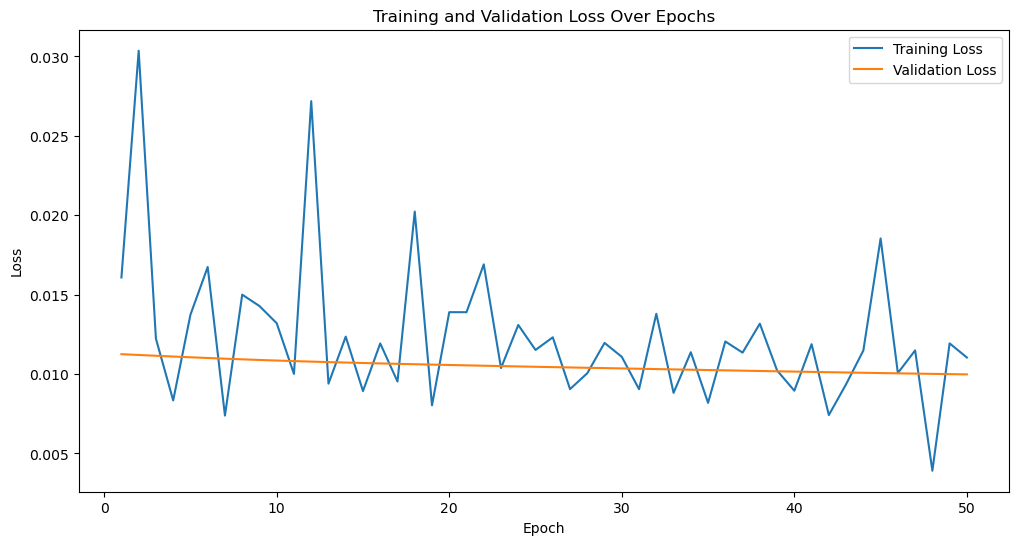

In [1120]:
# Plotting
epochs = np.arange(1, num_epochs + 1)
#Losses
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

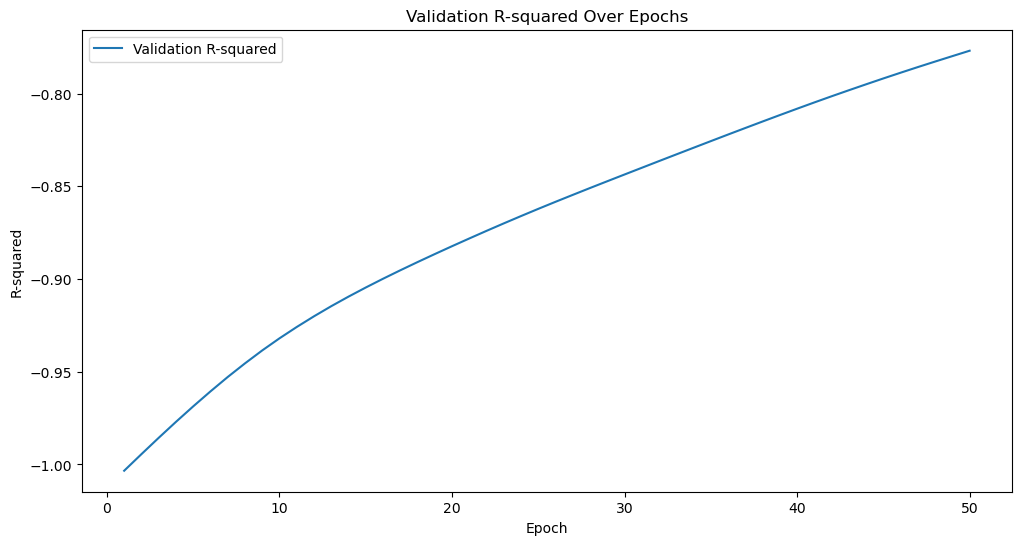

In [1121]:
#R-squared values
plt.figure(figsize=(12, 6))
plt.plot(epochs, val_r_squared_values, label='Validation R-squared')
plt.xlabel('Epoch')
plt.ylabel('R-squared')
plt.title('Validation R-squared Over Epochs')
plt.legend()
plt.show()

In [1122]:
# Testing
model.eval()
test_loss = 0.0
all_predictions = []
all_targets = []

with torch.no_grad():
    for test_batch_x, test_batch_y in test_loader:
        test_outputs = model(test_batch_x)
        test_batch_y = test_batch_y.view(-1, 1)  # Ensure the target tensor has shape [batch_size, 1]
        test_loss += criterion(test_outputs, test_batch_y).item()

        all_predictions.extend(test_outputs.numpy())
        all_targets.extend(test_batch_y.numpy())

test_loss /= len(test_loader)

# Calculate R-squared
r_squared_MLP3 = calculate_r_squared(all_targets, all_predictions)

print(f'Test Loss: {test_loss:.4f}')
print(f'R-squared: {r_squared_MLP3:.4f}')

print('Training and Testing finished.')

Test Loss: 0.0150
R-squared: -0.4212
Training and Testing finished.


Text(0.5, 1.0, 'Actual vs. Predicted Test Set')

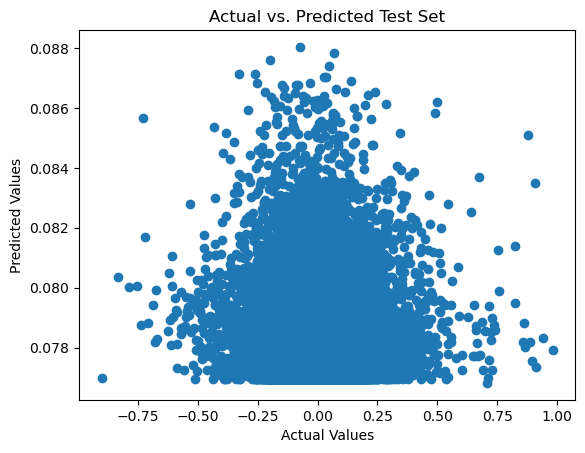

In [1123]:
plt.scatter(all_targets, all_predictions)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Test Set')

In [1124]:
#Export out
predictions = [item for sublist in all_predictions for item in sublist]
output_mlp3 = output.copy()
output_mlp3['pred'] = predictions
output_mlp3.to_csv('output_mlp3.csv', index=False)
output_mlp3.head()

,permno,DATE,RET,pred
0,14593,202112,0.074229,0.081378
1,14593,202109,-0.068037,0.081815
2,10107,202111,-0.001236,0.078306
3,10107,202112,0.017333,0.078301
4,14593,202111,0.104940,0.081539


## Summary

In [1125]:
print(f'MLP w/ 1 Hidden Layer R-squared: {r_squared_MLP1:.4f}')
print(f'MLP w/ 2 Hidden Layers R-squared: {r_squared_MLP2:.4f}')
print(f'MLP w/ 3 Hidden Layers R-squared: {r_squared_MLP3:.4f}')

MLP w/ 1 Hidden Layer R-squared: -4.8502
MLP w/ 2 Hidden Layers R-squared: -0.0098
MLP w/ 3 Hidden Layers R-squared: -0.4212


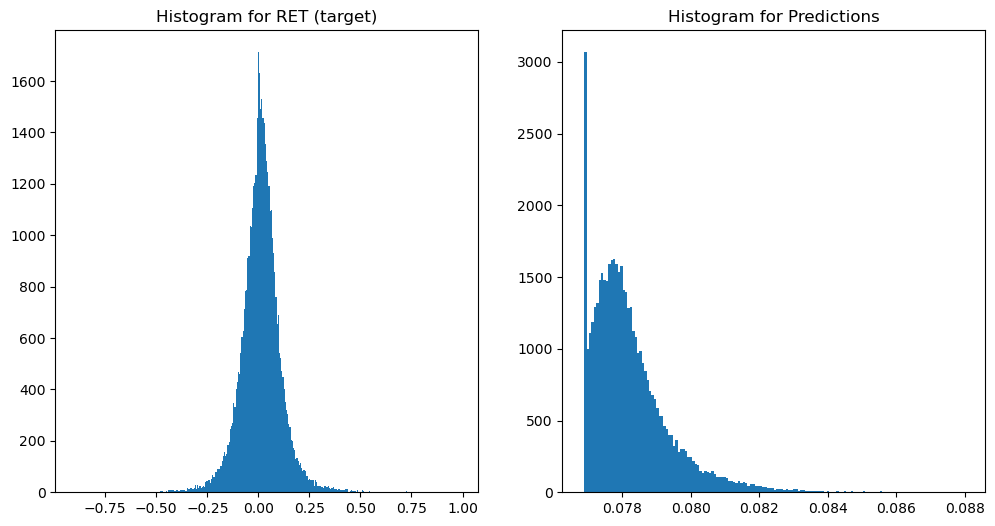

In [1126]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
axes[0].hist(output_mlp3['RET'], bins='auto')
axes[0].set_title('Histogram for RET (target)')
axes[1].hist(output_mlp3['pred'], bins='auto')
axes[1].set_title('Histogram for Predictions')
plt.show()